# Comparison of Divergence (Conservation) and Skew-Symmetric (Split) Forms of the Inviscid Burgers' Equation

In [50]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
using Plots; pyplot()
path = "../results/burgers_divergence_vs_split_smooth_m8/"

"../results/burgers_divergence_vs_split_smooth_m8/"

In [51]:
L = 2.0  # domain length
T = 0.5  # end time
M = 20  # number of elements
p = 4  # degree of discretization
k = Float64(8*π)

# DMD parameters
n_s = 100
r = 10
tol = -1.0

ec_flux = EntropyConservativeNumericalFlux{BurgersFlux{1}}()
central_flux = LaxFriedrichsNumericalFlux{BurgersFlux{1}}(0.0)
lf_flux = LaxFriedrichsNumericalFlux{BurgersFlux{1}}(1.0)


initial_data = InitialDataGassner(1,k)
conservation_law = burgers_equation(
    source_term=SourceTermGassner(1,k),
    numerical_flux=lf_flux);

reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=50)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
strategy = Eager()

dt_scale=0.01
dt = dt_scale*(L/M)/(2*p+1)
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization);

Conservation form

In [52]:
results_path_d = string(path,"divergence_form/")
form_d = StrongConservationForm()
solver_d = Solver(conservation_law, spatial_discretization, form_d, strategy)
results_path_d = save_project(conservation_law,
     spatial_discretization, initial_data, form_d, 
     (0.0, T), strategy, results_path_d, overwrite=true, clear=true);

In [53]:
conservation_analysis_d = PrimaryConservationAnalysis(results_path_d, 
    conservation_law, spatial_discretization)
energy_analysis_d = EnergyConservationAnalysis(results_path_d, 
    conservation_law, spatial_discretization)
dmd_analysis_d = DMDAnalysis(results_path_d, conservation_law, 
    spatial_discretization, r=r, n_s=n_s, tol=tol);

In [54]:
ode_problem_d = semidiscretize(solver_d, u0, (0.0, T))
save_solution(u0, 0.0, results_path_d, 0)
sol_d = solve(ode_problem_d, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path_d, floor(Int, n_t/(n_s-1))))
save_solution(last(sol_d.u), last(sol_d.t), results_path_d, "final");

Conservation (initial/final/diff):
[0.019999999999999934][0.020000000000003293][3.3584246494910985e-15]
Energy (initial/final/diff):
[1.0002000000000009][1.0076457636624851][0.007445763662484284]
Max amplification: (1.0083517126795833, 6)
10


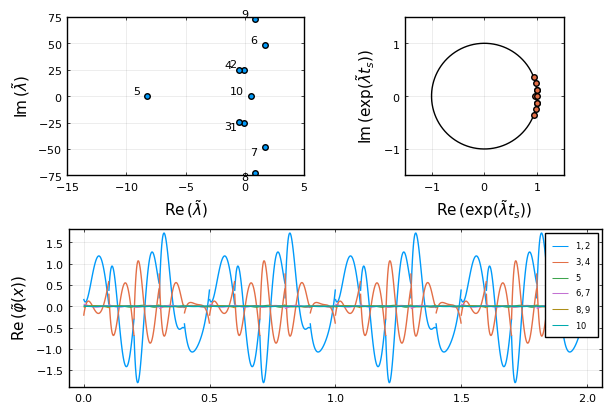

Plot{Plots.PyPlotBackend() n=9}

In [65]:
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis_d)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis_d)...)
dmd_results_d = analyze(dmd_analysis_d)
println("Max amplification: ", findmax(abs.(dmd_results_d.σ)))
show(plot_analysis(dmd_analysis_d, dmd_results_d, i=1, n=0, xlims=(-15.0, 5.0), ylims=(-75.0,75.0)))

Split Form

In [56]:
results_path_s = string(path,"split_form/")
form_s = StrongFluxDiffForm()
solver_s = Solver(conservation_law, spatial_discretization, form_s, strategy)
results_path_s = save_project(conservation_law,
     spatial_discretization, initial_data, form_s, 
     (0.0, T), strategy, results_path_s, overwrite=true, clear=true);

In [57]:
conservation_analysis_s = PrimaryConservationAnalysis(results_path_s, 
    conservation_law, spatial_discretization)
energy_analysis_s = EnergyConservationAnalysis(results_path_s, 
    conservation_law, spatial_discretization)
dmd_analysis_s = DMDAnalysis(results_path_s, conservation_law, 
    spatial_discretization, r=r, n_s = n_s, tol=tol);

In [58]:
ode_problem_s = semidiscretize(solver_s, u0, (0.0, T))
save_solution(u0, 0.0, results_path_s, 0)
sol_s = solve(ode_problem_s, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path_s, floor(Int, n_t/(n_s-1))))
save_solution(last(sol_s.u), last(sol_s.t), results_path_s, "final");

Conservation (initial/final/diff):
[0.019999999999999934][0.020000000000001225][1.2906342661267445e-15]
Energy (initial/final/diff):
[1.0002000000000009][1.0012033418561448][0.0010033418561439245]
Max amplification:
(1.001450145748763, 7)
10


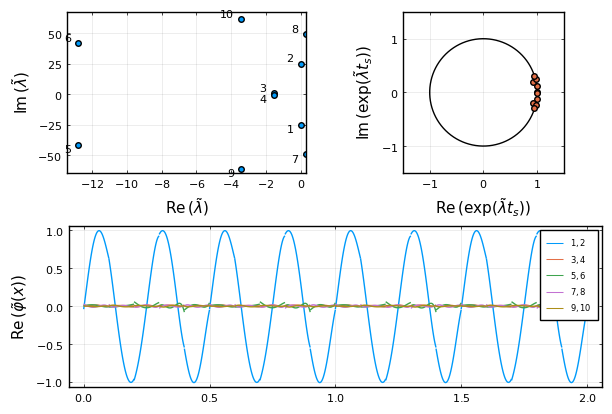

Plot{Plots.PyPlotBackend() n=8}

In [64]:
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis_s)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis_s)...)
dmd_results_s = analyze(dmd_analysis_s)
println("Max amplification:\n", findmax(abs.(dmd_results_s.σ)))
show(plot_analysis(dmd_analysis_s, dmd_results_s, i=1, n=0))

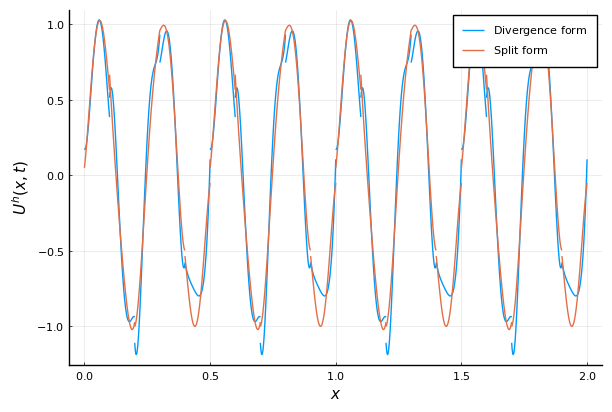

Plot{Plots.PyPlotBackend() n=2}

In [63]:
plotter = Plotter(spatial_discretization, path)
show(visualize([last(sol_d.u), last(sol_s.u)], ["\\mathrm{Divergence}\\ \\mathrm{form}", "\\mathrm{Split}\\ \\mathrm{form}"],
    "numerical_solutions.pdf", plotter))